# Exploration
Constant VPD experiment: ```/glade/campaign/univ/uwas0098/cnstVPDforPhoto_PI_SOM/tseries/TimeSeries/```

Control experiment:
```/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/COUP0000_PI_SOM/domain/proc/tseries/```

# Setup

In [106]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import pickle as pkl

import cartopy
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.path as mpath

import matplotlib.gridspec as gs

import cmocean.cm as cmo

In [2]:
## Some magic to automatically reload my functions before running a new cell
%load_ext autoreload
%autoreload 1
%aimport climate_data_science_functions

import climate_data_science_functions as cds

## Figure settings

In [3]:
## Adjust dpi
mpl.rcParams['figure.dpi'] = 80

## Assign figure output format
# %config InlineBackend.figure_formats = ['pdf']
%config InlineBackend.figure_formats = ['png']

# Import data

In [4]:
## Constant VPD experiment
path_cstvpd = '/glade/campaign/univ/uwas0098/cnstVPDforPhoto_PI_SOM/tseries/TimeSeries/'

varlist_cstvpd = []
for file in os.listdir(path_cstvpd):
    varlist_cstvpd.append(file.split('.')[5])
varlist_cstvpd = sorted(varlist_cstvpd)

In [5]:
## Control VPD experiment
basepath_ctlvpd = '/glade/campaign/cgd/tss/czarakas/CoupledPPE/'
ensemble = 'coupled'
domain = 'atm'

if ensemble == 'offline':
    ensemble_path = 'offline_simulations'
    refcase_id = 'OFFL0000_PI_v02'
elif ensemble == 'coupled':
    ensemble_path = 'coupled_simulations'
    refcase_id = 'COUP0000_PI_SOM'

if domain == 'atm':
    domain_suffix = '.cam.h0.'
elif domain == 'lnd':
    domain_suffix = '.clm2.h0.'

path_ctlvpd = basepath_ctlvpd+ensemble_path+'/'+refcase_id+'/'+domain+'/proc/tseries/'

varlist_ctlvpd = []
for file in os.listdir(path_ctlvpd):
    if file.split('.')[2] == 'h0':
        varlist_ctlvpd.append(file.split('.')[4])
varlist_ctlvpd = sorted(varlist_ctlvpd)

In [13]:
## Get the variables in common between the two experiments
set_cstvpd = set(varlist_cstvpd)
set_ctlvpd = set(varlist_ctlvpd)
varlist = sorted(list(set_cstvpd.intersection(set_ctlvpd)))

print('Preprocessed timeseries variables available for constant VPD and control experiments:')
varlist

Preprocessed timeseries variables available for constant VPD and control experiments:


['CLDHGH',
 'CLDLOW',
 'CLDMED',
 'CLDTOT',
 'FLDS',
 'FLNS',
 'FLNSC',
 'FLNT',
 'FLNTC',
 'FLUT',
 'FSDS',
 'FSDSC',
 'FSNS',
 'FSNSC',
 'FSNT',
 'FSNTC',
 'ICEFRAC',
 'LHFLX',
 'PRECC',
 'PRECL',
 'PRECSC',
 'PRECSL',
 'Q',
 'SHFLX',
 'TREFHT',
 'TS']

In [7]:
## Overlapping time period between control and constat VPD experiments
tslice = slice('0049-02','0083-01')

# Dictionaries and constants

In [68]:
## Load csv file of all CESM2-LENS output variables
cesm2_all_vars = pd.read_csv('/glade/u/home/bbuchovecky/references/CESM2-LENS_output_variables.csv', index_col=0, header=0)

## Get atmosphere variables and save to pickle file
cesm2_atm_std_latlon = cesm2_all_vars.loc[(cesm2_all_vars['temporal_frequency']=='month_1')
                                          & (cesm2_all_vars['component']=='std')
                                          & (cesm2_all_vars['domain']=='atm')
                                          & (cesm2_all_vars['dimensions']=='time lat lon')].to_dict(orient='index')
with open('/glade/u/home/bbuchovecky/references/cesm2_atm_std_latlon.pkl', 'wb') as handle:
    pkl.dump(cesm2_atm_std_latlon, handle, protocol=pkl.HIGHEST_PROTOCOL)

## Get land variables and save to pickle file
cesm2_lnd_std_latlon = cesm2_all_vars.loc[(cesm2_all_vars['temporal_frequency']=='month_1')
                                          & (cesm2_all_vars['component']=='std')
                                          & (cesm2_all_vars['domain']=='lnd')
                                          & (cesm2_all_vars['dimensions']=='time lat lon')].to_dict(orient='index')
with open('/glade/u/home/bbuchovecky/references/cesm2_lnd_std_latlon.pkl', 'wb') as handle:
    pkl.dump(cesm2_lnd_std_latlon, handle, protocol=pkl.HIGHEST_PROTOCOL)

In [78]:
## Load dictionaries
with open('/glade/u/home/bbuchovecky/references/cesm2_atm_std_latlon.pkl', 'rb') as handle:
    cesm2_atm_std_latlon = pkl.load(handle)
with open('/glade/u/home/bbuchovecky/references/cesm2_lnd_std_latlon.pkl', 'rb') as handle:
    cesm2_lnd_std_latlon = pkl.load(handle)
    
## Print keys available for each variable
cesm2_lnd_std_latlon[list(cesm2_lnd_std_latlon.keys())[0]].keys()

dict_keys(['domain', 'component', 'temporal_frequency', 'time_averaging', 'long_name', 'units', 'dimensions'])

In [87]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Masks

## Land mask

In [8]:
input_topo = xr.open_dataset('/glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_1.9x2.5_nc3000_Nsw084_Nrs016_Co120_Fi001_ZR_GRNL_c190405.nc')
lf = input_topo['LANDFRAC']

Text(0.5, 1.0, 'land mask')

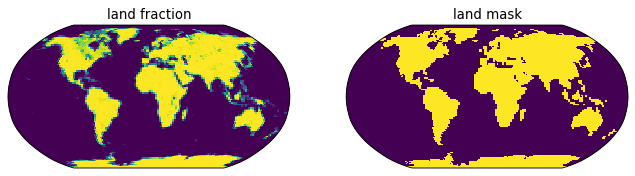

In [9]:
## Set 25% as the minimum land fraction for 'land' categorization 
landthresh = 0.25
landmask = xr.where(lf>landthresh,True,False)

mapproj = ccrs.Robinson()
fig,ax = plt.subplots(1,2,figsize=(10,3),subplot_kw={'projection':mapproj})
lf.plot(ax=ax[0], add_colorbar=False, transform=ccrs.PlateCarree())
landmask.plot(ax=ax[1], add_colorbar=False, transform=ccrs.PlateCarree())

ax[0].set_title('land fraction')
ax[1].set_title('land mask')

## Latitude masks

In [165]:
## Latitude bounds: 0<tropics<=30, 30<temp<=65, 65<polar<90
nh_hgh = xr.where(lf.where((lf.lat>65),2)!=2, True ,False)
sh_hgh = xr.where(lf.where((lf.lat<-65),2)!=2, True, False)
nh_mid = xr.where(lf.where((lf.lat>30) & (lf.lat<=65),2)!=2, True, False)
sh_mid = xr.where(lf.where((lf.lat<-30) & (lf.lat>=-65),2)!=2, True, False)
tropic = xr.where(lf.where((lf.lat<=30) & (lf.lat>=-30),2)!=2, True, False)

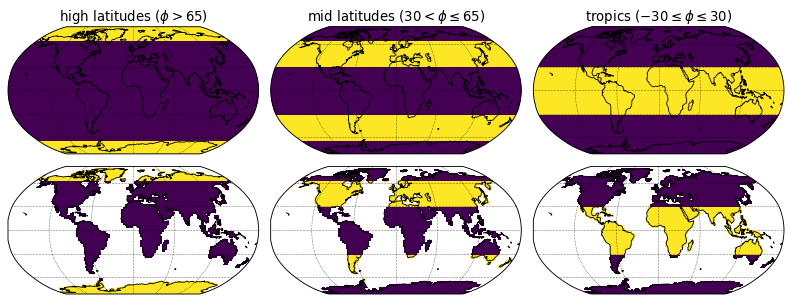

In [181]:
mapproj = ccrs.Robinson()
fig,axes = plt.subplots(2,3,figsize=(10,4),subplot_kw={'projection':mapproj})
ax = axes.ravel()

(nh_hgh+sh_hgh).plot(ax=ax[0], add_colorbar=False, transform=ccrs.PlateCarree())
(nh_mid+sh_mid).plot(ax=ax[1], add_colorbar=False, transform=ccrs.PlateCarree())
tropic.plot(ax=ax[2], add_colorbar=False, transform=ccrs.PlateCarree())

(nh_hgh+sh_hgh).where(landmask).plot(ax=ax[3], add_colorbar=False, transform=ccrs.PlateCarree())
(nh_mid+sh_mid).where(landmask).plot(ax=ax[4], add_colorbar=False, transform=ccrs.PlateCarree())
tropic.where(landmask).plot(ax=ax[5], add_colorbar=False, transform=ccrs.PlateCarree())

ax[0].set_title('high latitudes ($\phi > 65$)')
ax[1].set_title('mid latitudes ($30 < \phi \leq 65$)')
ax[2].set_title('tropics ($-30 \leq \phi \leq 30$)')

for a in ax:
    a.coastlines(lw=0.75)
    cds.add_cartopy_gridlines(a, mapproj)
    
fig.tight_layout()

# Near-surface air temperature

In [10]:
var = 'TREFHT'
convertadd = -273.15

tref_ctl = xr.open_dataset(path_ctlvpd+refcase_id+domain_suffix+'timeseries.'+var+'.nc')[var].sel(time=tslice) + convertadd
tref_vpd = xr.open_dataset(path_cstvpd+'cnstVPDforPhoto_PI_SOM.cam.h0.ts.allyears.'+var+'.nc')[var].sel(time=tslice) + convertadd

## Single month

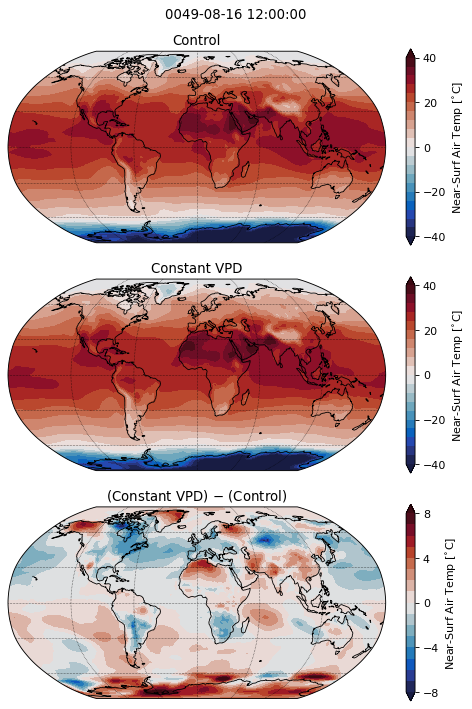

In [11]:
ixt = 6

lon = tref_ctl.lon
mapproj = ccrs.Robinson()
cmap = cmo.balance
cflevels = np.arange(-40,40.1,4)
cbticks = [-40,-20,0,20,40]
cblabel = 'Near-Surf Air Temp [$^{\circ}$C]'

fig,axes = plt.subplots(3,1,figsize=(6,9),subplot_kw={'projection':mapproj})
ax = axes.ravel()

cf_ctl = cds.cyclic_contourf(ax[0], tref_ctl.isel(time=ixt),
                             levels=cflevels, cmap=cmap, extend='both',
                             transform=ccrs.PlateCarree())
cb_ctl = fig.colorbar(cf_ctl, ax=ax[0], fraction=0.025, label=cblabel)
cb_ctl.set_ticks(cbticks)
ax[0].set_title('Control')

cf_vpd = cds.cyclic_contourf(ax[1], tref_vpd.isel(time=ixt),
                             levels=cflevels, cmap=cmap, extend='both',
                             transform=ccrs.PlateCarree())
cb_vpd = fig.colorbar(cf_vpd, ax=ax[1], fraction=0.025, label=cblabel)
cb_vpd.set_ticks(cbticks)
ax[1].set_title('Constant VPD')

cf_dif = cds.cyclic_contourf(ax[2], tref_vpd.isel(time=ixt)-tref_ctl.isel(time=ixt),
                             levels=np.arange(-8,8.1,1), cmap=cmap, extend='both',
                             transform=ccrs.PlateCarree())
cb_dif = fig.colorbar(cf_dif, ax=ax[2], fraction=0.025, label=cblabel)
cb_dif.set_ticks([-8,-4,0,4,8])
ax[2].set_title('(Constant VPD) $-$ (Control)')

for a in ax:
    a.coastlines(lw=0.75)
    cds.add_cartopy_gridlines(a, mapproj)

fig.suptitle(tref_ctl.time.isel(time=ixt).values)
fig.tight_layout()

## Time average

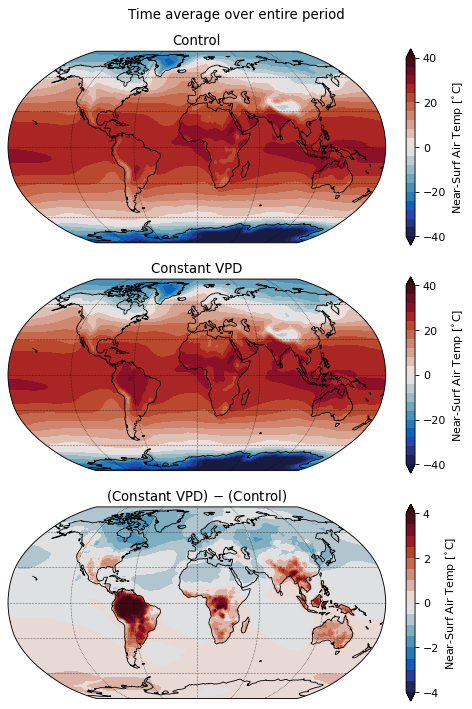

In [136]:
lon = tref_ctl.lon
mapproj = ccrs.Robinson()
cmap = cmo.balance
cflevels = np.arange(-40,40.1,4)
cbticks = [-40,-20,0,20,40]
cblabel = 'Near-Surf Air Temp [$^{\circ}$C]'

fig,axes = plt.subplots(3,1,figsize=(6,9),subplot_kw={'projection':mapproj})
ax = axes.ravel()

cf_ctl = cds.cyclic_contourf(ax[0], tref_ctl.mean(dim='time'),
                             levels=cflevels, cmap=cmap, extend='both',
                             transform=ccrs.PlateCarree())
cb_ctl = fig.colorbar(cf_ctl, ax=ax[0], fraction=0.025, label=cblabel)
cb_ctl.set_ticks(cbticks)
ax[0].set_title('Control')

cf_vpd = cds.cyclic_contourf(ax[1], tref_vpd.mean(dim='time'),
                             levels=cflevels, cmap=cmap, extend='both',
                             transform=ccrs.PlateCarree())
cb_vpd = fig.colorbar(cf_vpd, ax=ax[1], fraction=0.025, label=cblabel)
cb_vpd.set_ticks(cbticks)
ax[1].set_title('Constant VPD')

cf_dif = cds.cyclic_contourf(ax[2], tref_vpd.mean(dim='time')-tref_ctl.mean(dim='time'),
                             levels=np.arange(-4,4.1,0.5), cmap=cmap, extend='both',
                             transform=ccrs.PlateCarree())
cb_dif = fig.colorbar(cf_dif, ax=ax[2], fraction=0.025, label=cblabel)
cb_dif.set_ticks([-4,-2,0,2,4])
ax[2].set_title('(Constant VPD) $-$ (Control)')

for a in ax:
    a.coastlines(lw=0.75)
    cds.add_cartopy_gridlines(a, mapproj)

fig.suptitle('Time average over entire period')
fig.tight_layout()

## Seasonal cycle maps

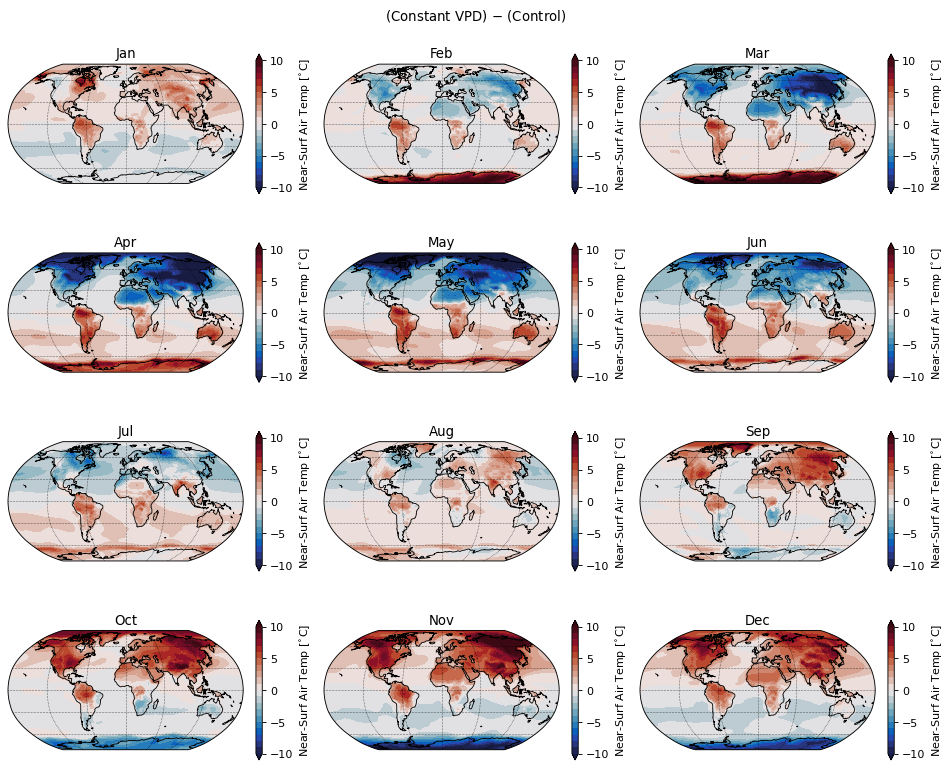

In [36]:
## Analysis
tref_ctl_clim = tref_ctl.groupby('time.month').mean(dim='time')
tref_vpd_clim = tref_vpd.groupby('time.month').mean(dim='time')

## Visualization
lon = tref_ctl.lon
mapproj = ccrs.Robinson()
cmap = cmo.balance
cflevels = np.arange(-10,10.1,1)
cbticks = [-10,-5,0,5,10]
cblabel = 'Near-Surf Air Temp [$^{\circ}$C]'
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig,axes = plt.subplots(4,3,figsize=(12,10),subplot_kw={'projection':mapproj})
ax = axes.ravel()

for i,a in enumerate(ax):
    cf_dif = cds.cyclic_contourf(a, tref_vpd_clim.isel(month=i)-tref_ctl_clim.isel(month=i),
                                 levels=cflevels, cmap=cmap, extend='both',
                                 transform=ccrs.PlateCarree())
    cb_dif = fig.colorbar(cf_dif, ax=a, fraction=0.025, label=cblabel)
    cb_dif.set_ticks(cbticks)
    a.set_title(months[i])
    a.coastlines(lw=0.75)
    cds.add_cartopy_gridlines(a, mapproj)

fig.suptitle('(Constant VPD) $-$ (Control)')
fig.tight_layout()

## Global areal average

In [103]:
# Compute the global mean using cosine(lat) weighting
lat = tref_ctl.lat
coslat_weights = np.cos(lat * np.pi / 180)
tref_ctl_globmean = (tref_ctl.mean(dim='lon') * coslat_weights).sum(dim='lat') / coslat_weights.sum()
tref_vpd_globmean = (tref_vpd.mean(dim='lon') * coslat_weights).sum(dim='lat') / coslat_weights.sum()

# Compute climatology
tref_ctl_globclim = tref_ctl_globmean.groupby('time.month').mean()
tref_vpd_globclim = tref_vpd_globmean.groupby('time.month').mean()

# Compute anomalies from climatology
tref_ctl_globanom = tref_ctl_globmean.groupby('time.month') - tref_ctl_globclim
tref_vpd_globanom = tref_vpd_globmean.groupby('time.month') - tref_vpd_globclim

### Seasonal cycle timeseries

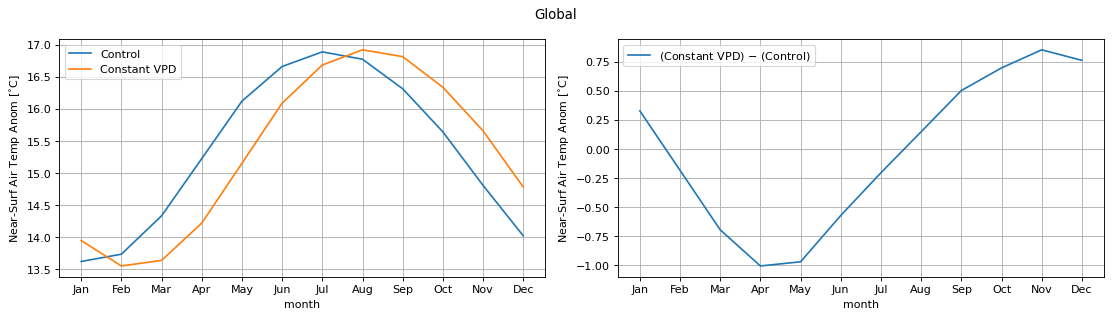

In [193]:
# Visualization
fig,ax = plt.subplots(1,2,figsize=(14,4))

tref_ctl_globclim.plot(ax=ax[0], label='Control')
tref_vpd_globclim.plot(ax=ax[0], label='Constant VPD')

(tref_vpd_globclim-tref_ctl_globclim).plot(ax=ax[1], label='(Constant VPD) $-$ (Control)')

for a in ax:
    a.set_xticks(np.arange(1,13))
    a.set_xticklabels(months)
    a.set_ylabel('Near-Surf Air Temp Anom [$^{\circ}$C]')
    a.legend()
    a.grid()
    
fig.suptitle('Global')
fig.tight_layout()

### Full timeseries of anomalies (deviation from seasonal cycle)

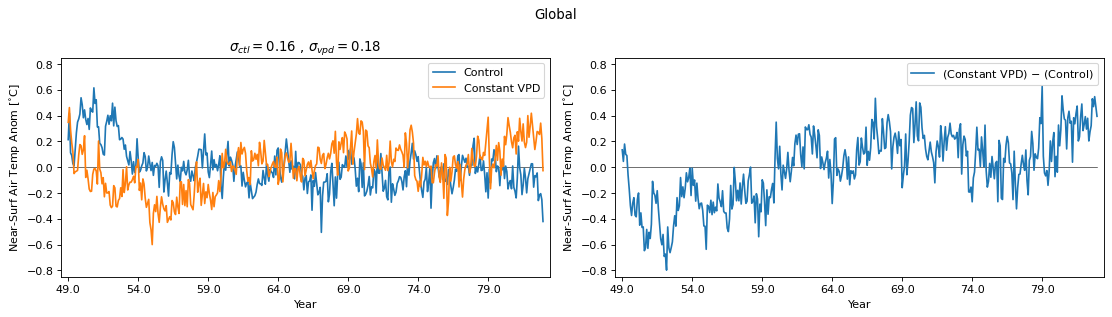

In [194]:
# Visualization
time = np.arange(49*12,83*12)

fig,ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(time, tref_ctl_globanom.values, label='Control')
ax[0].plot(time, tref_vpd_globanom.values, label='Constant VPD')
ax[0].legend()
ax[0].set_title('$\sigma_{ctl}=$'+str(tref_ctl_globanom.std().values.round(2))+' , '+
                '$\sigma_{vpd}=$'+str(tref_vpd_globanom.std().values.round(2)))

ax[1].plot(time, tref_vpd_globanom.values-tref_ctl_globanom.values, label='(Constant VPD) $-$ (Control)')
ax[1].legend()

for a in ax:
    a.plot([time[0],time[-1]], [0,0], linewidth=0.5, color='k', zorder=0)
    a.set_ylim(-0.85,0.85)
    a.set_xlim(time[0]-6, time[-1]+6)
    a.set_xticks(time[::12*5])
    a.set_xticklabels(time[::12*5]/12)
    a.set_xlabel('Year')
    a.set_ylabel('Near-Surf Air Temp Anom [$^{\circ}$C]')
    
fig.suptitle('Global')
fig.tight_layout()

## Land areal average

In [119]:
# Compute the global mean using cosine(lat) weighting
lat = tref_ctl.lat
coslat_weights = np.cos(lat * np.pi / 180)
tref_ctl_landmean = (tref_ctl.where(landmask).mean(dim='lon') * coslat_weights).sum(dim='lat') / coslat_weights.sum()
tref_vpd_landmean = (tref_vpd.where(landmask).mean(dim='lon') * coslat_weights).sum(dim='lat') / coslat_weights.sum()

# Compute climatology
tref_ctl_landclim = tref_ctl_landmean.groupby('time.month').mean()
tref_vpd_landclim = tref_vpd_landmean.groupby('time.month').mean()

# Compute anomalies from climatology
tref_ctl_landanom = tref_ctl_landmean.groupby('time.month') - tref_ctl_landclim
tref_vpd_landanom = tref_vpd_landmean.groupby('time.month') - tref_vpd_landclim

### Seasonal cycle timeseries

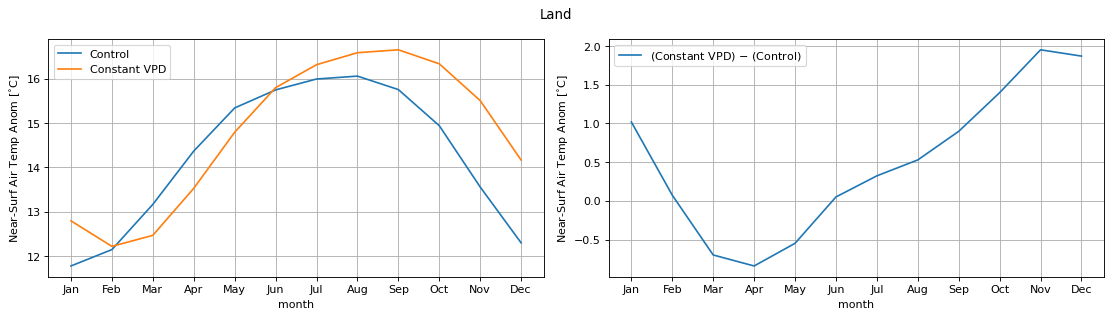

In [192]:
# Visualization
fig,ax = plt.subplots(1,2,figsize=(14,4))

tref_ctl_landclim.plot(ax=ax[0], label='Control')
tref_vpd_landclim.plot(ax=ax[0], label='Constant VPD')

(tref_vpd_landclim-tref_ctl_landclim).plot(ax=ax[1], label='(Constant VPD) $-$ (Control)')

for a in ax:
    a.set_xticks(np.arange(1,13))
    a.set_xticklabels(months)
    a.set_ylabel('Near-Surf Air Temp Anom [$^{\circ}$C]')
    a.legend()
    a.grid()
    
fig.suptitle('Land')
fig.tight_layout()

### Full timeseries of anomalies (deviation from seasonal cycle)

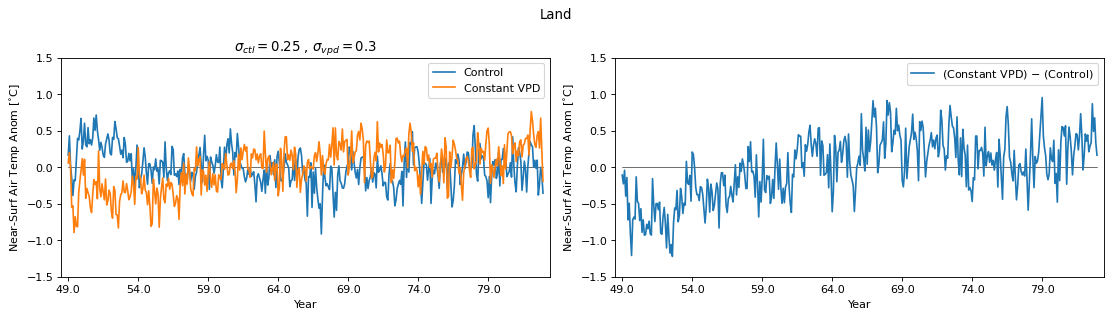

In [191]:
# Visualization
time = np.arange(49*12,83*12)

fig,ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(time, tref_ctl_landanom.values, label='Control')
ax[0].plot(time, tref_vpd_landanom.values, label='Constant VPD')
ax[0].legend()
ax[0].set_title('$\sigma_{ctl}=$'+str(tref_ctl_landanom.std().values.round(2))+' , '+
                '$\sigma_{vpd}=$'+str(tref_vpd_landanom.std().values.round(2)))

ax[1].plot(time, tref_vpd_landanom.values-tref_ctl_landanom.values, label='(Constant VPD) $-$ (Control)')
ax[1].legend()

for a in ax:
    a.plot([time[0],time[-1]], [0,0], linewidth=0.5, color='k', zorder=0)
    a.set_ylim(-1.5,1.5)
    a.set_xlim(time[0]-6, time[-1]+6)
    a.set_xticks(time[::12*5])
    a.set_xticklabels(time[::12*5]/12)
    a.set_xlabel('Year')
    a.set_ylabel('Near-Surf Air Temp Anom [$^{\circ}$C]')
    
fig.suptitle('Land')
fig.tight_layout()

# Precipitation

In [148]:
convfactor = 86400000

# Convective precipitation rate [m/s]->[mm/day]
var = 'PRECC'
precc_ctl = xr.open_dataset(path_ctlvpd+refcase_id+domain_suffix+'timeseries.'+var+'.nc')[var].sel(time=tslice) * convfactor
precc_vpd = xr.open_dataset(path_cstvpd+'cnstVPDforPhoto_PI_SOM.cam.h0.ts.allyears.'+var+'.nc')[var].sel(time=tslice) * convfactor

# Large-scale (stable) precipitation rate [m/s]->[mm/day]
var = 'PRECL'
precl_ctl = xr.open_dataset(path_ctlvpd+refcase_id+domain_suffix+'timeseries.'+var+'.nc')[var].sel(time=tslice) * convfactor
precl_vpd = xr.open_dataset(path_cstvpd+'cnstVPDforPhoto_PI_SOM.cam.h0.ts.allyears.'+var+'.nc')[var].sel(time=tslice) * convfactor

# Total precipitation [mm/day]
prec_ctl = precc_ctl + precl_ctl
prec_vpd = precc_vpd + precl_vpd

## Time average

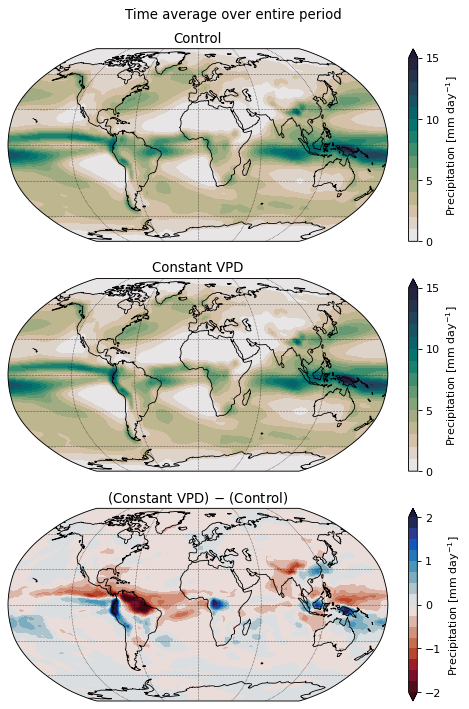

In [157]:
lon = tref_ctl.lon
mapproj = ccrs.Robinson()
cmap = cmo.rain
cflevels = np.arange(0,15.1,1)
cbticks = [0,5,10,15]
cblabel = 'Precipitation [mm day$^{-1}$]'

fig,axes = plt.subplots(3,1,figsize=(6,9),subplot_kw={'projection':mapproj})
ax = axes.ravel()

cf_ctl = cds.cyclic_contourf(ax[0], prec_ctl.mean(dim='time'),
                             levels=cflevels, cmap=cmap, extend='max',
                             transform=ccrs.PlateCarree())
cb_ctl = fig.colorbar(cf_ctl, ax=ax[0], fraction=0.025, label=cblabel)
cb_ctl.set_ticks(cbticks)
ax[0].set_title('Control')

cf_vpd = cds.cyclic_contourf(ax[1], prec_vpd.mean(dim='time'),
                             levels=cflevels, cmap=cmap, extend='max',
                             transform=ccrs.PlateCarree())
cb_vpd = fig.colorbar(cf_vpd, ax=ax[1], fraction=0.025, label=cblabel)
cb_vpd.set_ticks(cbticks)
ax[1].set_title('Constant VPD')

cf_dif = cds.cyclic_contourf(ax[2], prec_vpd.mean(dim='time')-prec_ctl.mean(dim='time'),
                             levels=np.arange(-2,2.1,0.25), cmap=cmo.balance_r, extend='both',
                             transform=ccrs.PlateCarree())
cb_dif = fig.colorbar(cf_dif, ax=ax[2], fraction=0.025, label=cblabel)
cb_dif.set_ticks([-2,-1,0,1,2])
ax[2].set_title('(Constant VPD) $-$ (Control)')

for a in ax:
    a.coastlines(lw=0.75)
    cds.add_cartopy_gridlines(a, mapproj)

fig.suptitle('Time average over entire period')
fig.tight_layout()

## Seasonal cycle maps

### Control only

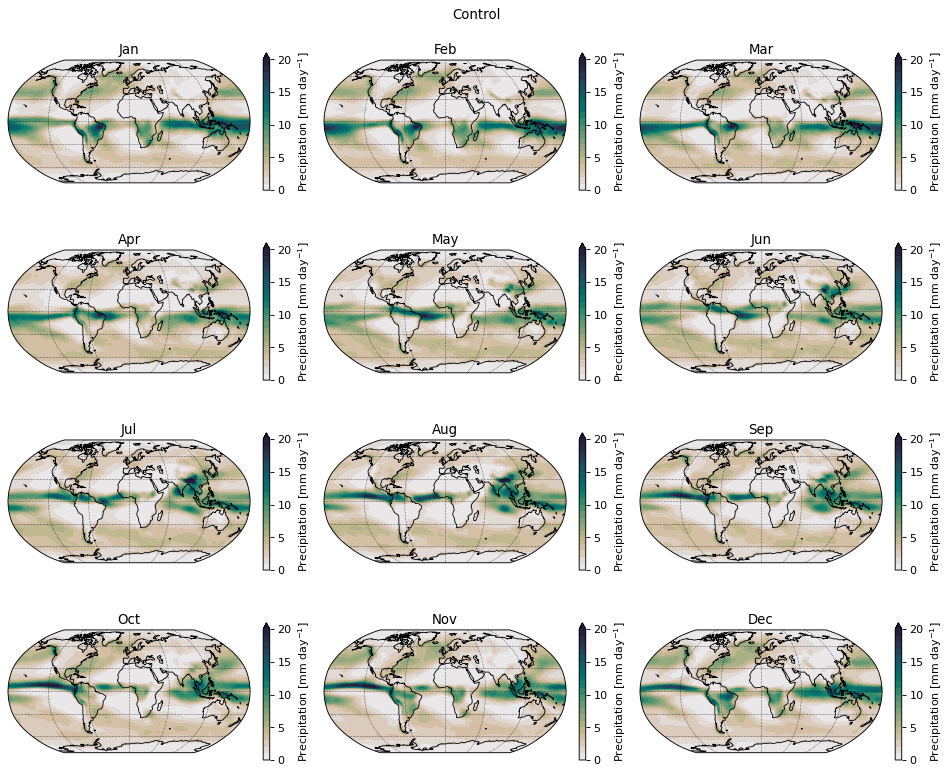

In [164]:
## Analysis
prec_ctl_clim = prec_ctl.groupby('time.month').mean(dim='time')

## Visualization
lon = prec_ctl.lon
mapproj = ccrs.Robinson()
cmap = cmo.rain
cflevels = np.arange(0,20.1,1)
cbticks = [0,5,10,15,20]
cblabel = 'Precipitation [mm day$^{-1}$]'
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig,axes = plt.subplots(4,3,figsize=(12,10),subplot_kw={'projection':mapproj})
ax = axes.ravel()

for i,a in enumerate(ax):
    cf_dif = cds.cyclic_contourf(a, prec_ctl_clim.isel(month=i),
                                 levels=cflevels, cmap=cmap, extend='max',
                                 transform=ccrs.PlateCarree())
    cb_dif = fig.colorbar(cf_dif, ax=a, fraction=0.025, label=cblabel)
    cb_dif.set_ticks(cbticks)
    a.set_title(months[i])
    a.coastlines(lw=0.75)
    cds.add_cartopy_gridlines(a, mapproj)

fig.suptitle('Control')
fig.tight_layout()

### Constant VPD only

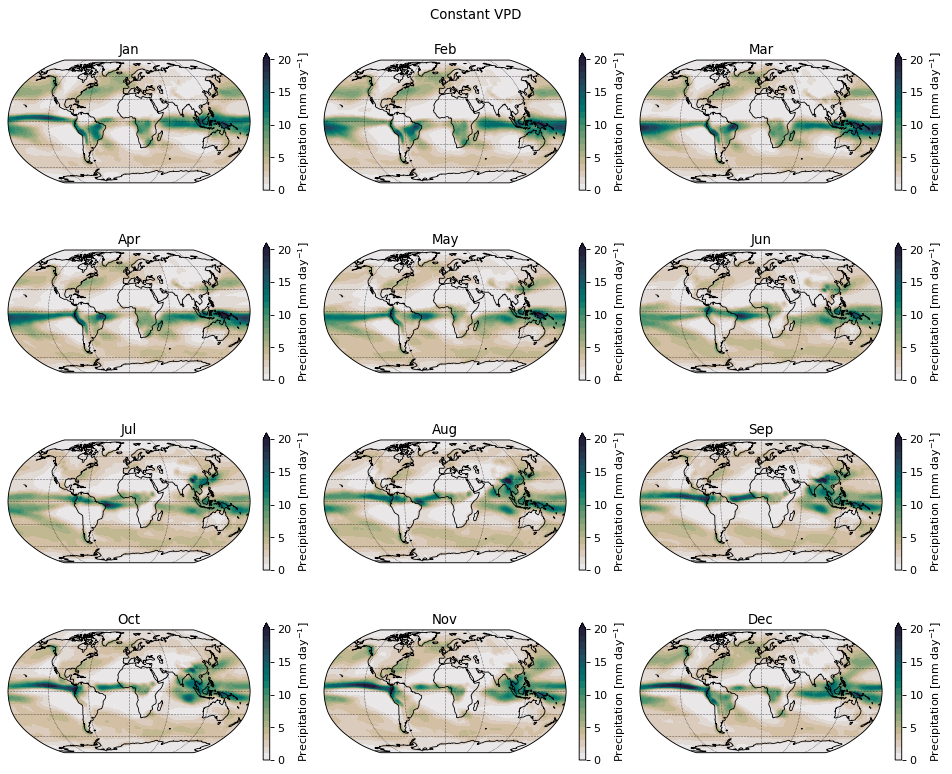

In [166]:
## Analysis
prec_vpd_clim = prec_vpd.groupby('time.month').mean(dim='time')

## Visualization
lon = prec_ctl.lon
mapproj = ccrs.Robinson()
cmap = cmo.rain
cflevels = np.arange(0,20.1,1)
cbticks = [0,5,10,15,20]
cblabel = 'Precipitation [mm day$^{-1}$]'
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig,axes = plt.subplots(4,3,figsize=(12,10),subplot_kw={'projection':mapproj})
ax = axes.ravel()

for i,a in enumerate(ax):
    cf_dif = cds.cyclic_contourf(a, prec_vpd_clim.isel(month=i),
                                 levels=cflevels, cmap=cmap, extend='max',
                                 transform=ccrs.PlateCarree())
    cb_dif = fig.colorbar(cf_dif, ax=a, fraction=0.025, label=cblabel)
    cb_dif.set_ticks(cbticks)
    a.set_title(months[i])
    a.coastlines(lw=0.75)
    cds.add_cartopy_gridlines(a, mapproj)

fig.suptitle('Constant VPD')
fig.tight_layout()

### Constant VPD $-$ Control

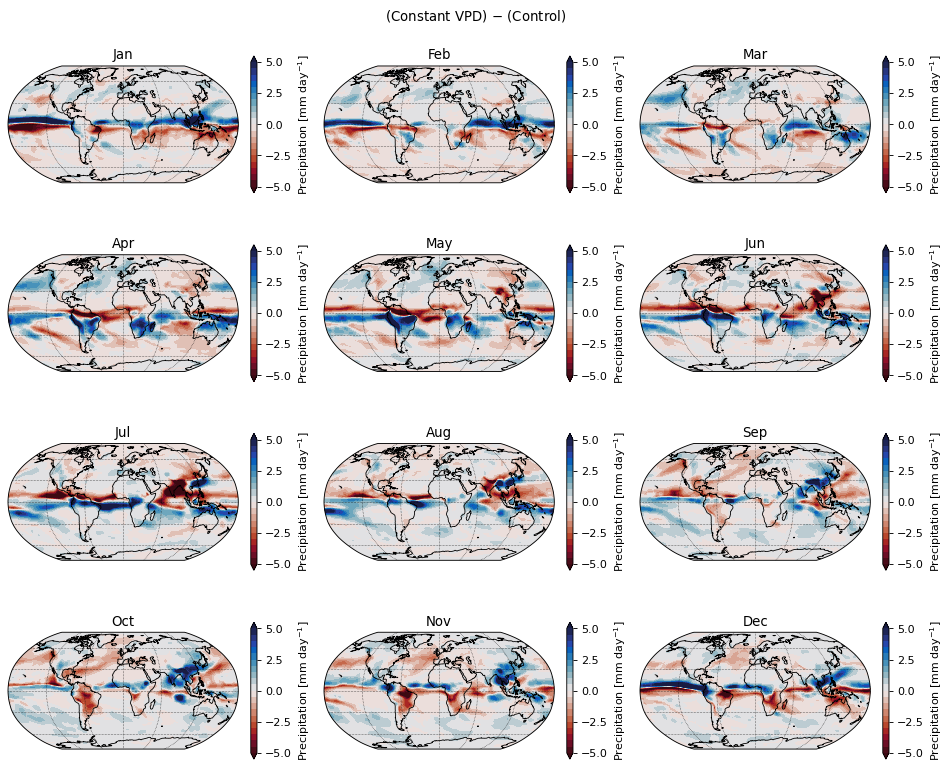

In [161]:
## Analysis
prec_ctl_clim = prec_ctl.groupby('time.month').mean(dim='time')
prec_vpd_clim = prec_vpd.groupby('time.month').mean(dim='time')

## Visualization
lon = prec_ctl.lon
mapproj = ccrs.Robinson()
cmap = cmo.balance_r
cflevels = np.arange(-5,5.1,0.5)
cbticks = [-5,-2.5,0,2.5,5]
cblabel = 'Precipitation [mm day$^{-1}$]'

fig,axes = plt.subplots(4,3,figsize=(12,10),subplot_kw={'projection':mapproj})
ax = axes.ravel()

for i,a in enumerate(ax):
    cf_dif = cds.cyclic_contourf(a, prec_vpd_clim.isel(month=i)-prec_ctl_clim.isel(month=i),
                                 levels=cflevels, cmap=cmap, extend='both',
                                 transform=ccrs.PlateCarree())
    cb_dif = fig.colorbar(cf_dif, ax=a, fraction=0.025, label=cblabel)
    cb_dif.set_ticks(cbticks)
    a.set_title(months[i])
    a.coastlines(lw=0.75)
    cds.add_cartopy_gridlines(a, mapproj)

fig.suptitle('(Constant VPD) $-$ (Control)')
fig.tight_layout()

## Global areal average

In [167]:
# Compute the global mean using cosine(lat) weighting
lat = prec_ctl.lat
coslat_weights = np.cos(lat * np.pi / 180)
prec_ctl_globmean = (prec_ctl.mean(dim='lon') * coslat_weights).sum(dim='lat') / coslat_weights.sum()
prec_vpd_globmean = (prec_vpd.mean(dim='lon') * coslat_weights).sum(dim='lat') / coslat_weights.sum()

# Compute climatology
prec_ctl_globclim = prec_ctl_globmean.groupby('time.month').mean()
prec_vpd_globclim = prec_vpd_globmean.groupby('time.month').mean()

# Compute anomalies from climatology
prec_ctl_globanom = prec_ctl_globmean.groupby('time.month') - prec_ctl_globclim
prec_vpd_globanom = prec_vpd_globmean.groupby('time.month') - prec_vpd_globclim

### Seasonal cycle timeseries

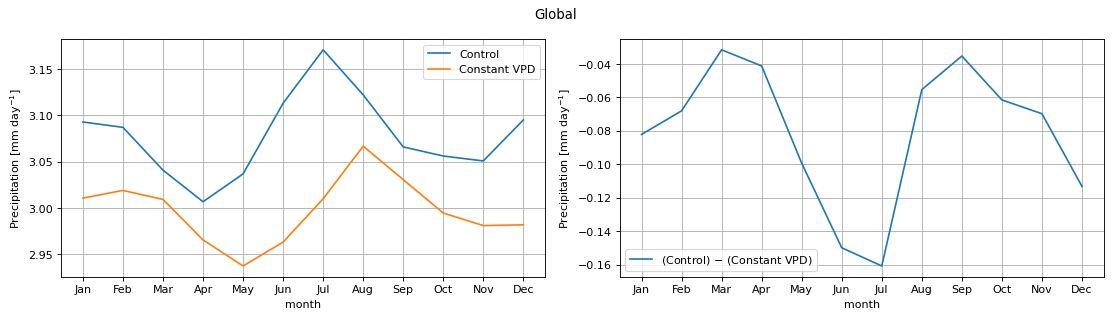

In [170]:
# Visualization
fig,ax = plt.subplots(1,2,figsize=(14,4))

prec_ctl_globclim.plot(ax=ax[0], label='Control')
prec_vpd_globclim.plot(ax=ax[0], label='Constant VPD')

(prec_vpd_globclim-prec_ctl_globclim).plot(ax=ax[1], label='(Control) $-$ (Constant VPD)')

for a in ax:
    a.set_xticks(np.arange(1,13))
    a.set_xticklabels(months)
    a.set_ylabel('Precipitation [mm day$^{-1}$]')
    a.legend()
    a.grid()
    
fig.suptitle('Global')
fig.tight_layout()

### Full timeseries of anomalies (deviation from seasonal cycle)

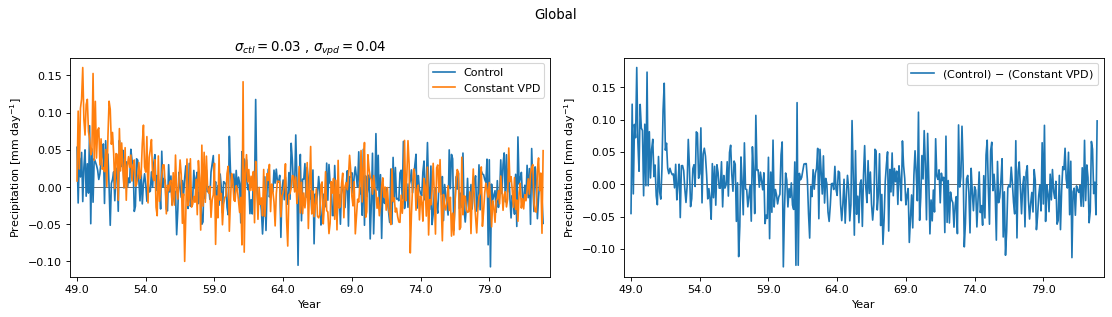

In [185]:
# Visualization
time = np.arange(49*12,83*12)

fig,ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(time, prec_ctl_globanom.values, label='Control')
ax[0].plot(time, prec_vpd_globanom.values, label='Constant VPD')
ax[0].legend()
ax[0].set_title('$\sigma_{ctl}=$'+str(prec_ctl_globanom.std().values.round(2))+' , '+
                '$\sigma_{vpd}=$'+str(prec_vpd_globanom.std().values.round(2)))

ax[1].plot(time, prec_vpd_globanom.values-prec_ctl_globanom.values, label='(Control) $-$ (Constant VPD)')
ax[1].legend()

for a in ax:
    a.plot([time[0],time[-1]], [0,0], linewidth=0.5, color='k', zorder=0)
    # a.set_ylim(-0.85,0.85)
    a.set_xlim(time[0]-6, time[-1]+6)
    a.set_xticks(time[::12*5])
    a.set_xticklabels(time[::12*5]/12)
    a.set_xlabel('Year')
    a.set_ylabel('Precipitation [mm day$^{-1}$]')
    
fig.suptitle('Global')
fig.tight_layout()

## Land areal average

In [172]:
# Compute the global mean using cosine(lat) weighting
lat = prec_ctl.lat
coslat_weights = np.cos(lat * np.pi / 180)
prec_ctl_landmean = (prec_ctl.where(landmask).mean(dim='lon') * coslat_weights).sum(dim='lat') / coslat_weights.sum()
prec_vpd_landmean = (prec_vpd.where(landmask).mean(dim='lon') * coslat_weights).sum(dim='lat') / coslat_weights.sum()

# Compute climatology
prec_ctl_landclim = prec_ctl_landmean.groupby('time.month').mean()
prec_vpd_landclim = prec_vpd_landmean.groupby('time.month').mean()

# Compute anomalies from climatology
prec_ctl_landanom = prec_ctl_landmean.groupby('time.month') - prec_ctl_landclim
prec_vpd_landanom = prec_vpd_landmean.groupby('time.month') - prec_vpd_landclim

### Seasonal cycle timeseries

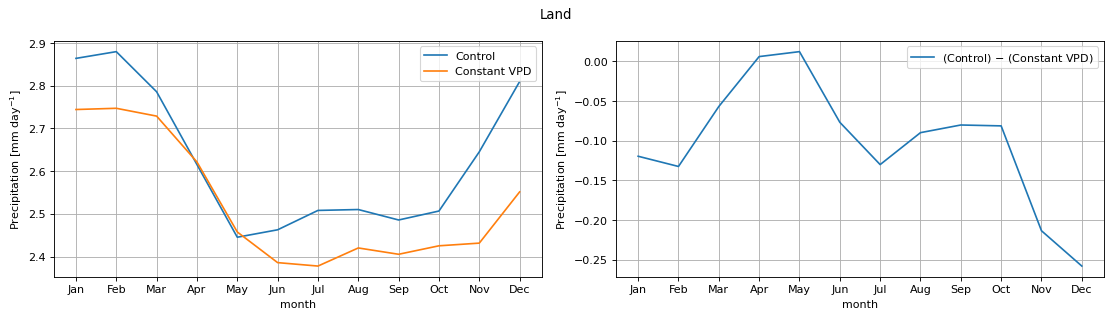

In [174]:
# Visualization
fig,ax = plt.subplots(1,2,figsize=(14,4))

prec_ctl_landclim.plot(ax=ax[0], label='Control')
prec_vpd_landclim.plot(ax=ax[0], label='Constant VPD')

(prec_vpd_landclim-prec_ctl_landclim).plot(ax=ax[1], label='(Control) $-$ (Constant VPD)')

for a in ax:
    a.set_xticks(np.arange(1,13))
    a.set_xticklabels(months)
    a.set_ylabel('Precipitation [mm day$^{-1}$]')
    a.legend()
    a.grid()
    
fig.suptitle('Land')
fig.tight_layout()

### Full timeseries of anomalies (deviation from seasonal cycle)

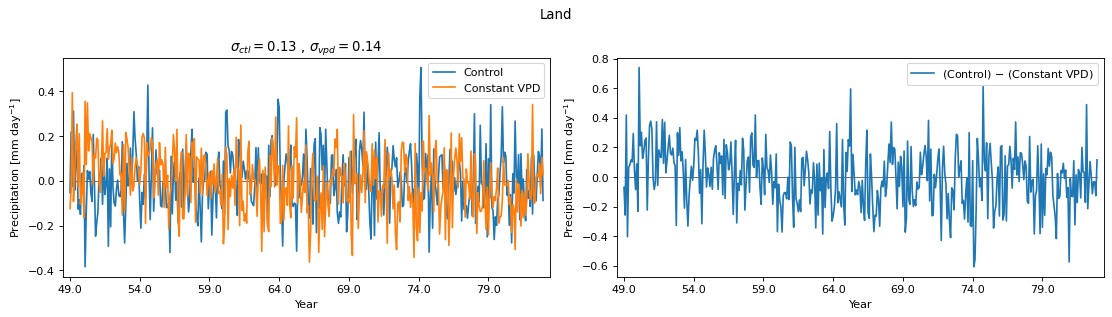

In [186]:
# Visualization
time = np.arange(49*12,83*12)

fig,ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(time, prec_ctl_landanom.values, label='Control')
ax[0].plot(time, prec_vpd_landanom.values, label='Constant VPD')
ax[0].set_title('$\sigma_{ctl}=$'+str(prec_ctl_landanom.std().values.round(2))+' , '+
                '$\sigma_{vpd}=$'+str(prec_vpd_landanom.std().values.round(2)))
ax[0].legend()

ax[1].plot(time, prec_vpd_landanom.values-prec_ctl_landanom.values, label='(Control) $-$ (Constant VPD)')
ax[1].legend()

for a in ax:
    a.plot([time[0],time[-1]], [0,0], linewidth=0.5, color='k', zorder=0)
    # a.set_ylim(-1.5,1.5)
    a.set_xlim(time[0]-6, time[-1]+6)
    a.set_xticks(time[::12*5])
    a.set_xticklabels(time[::12*5]/12)
    a.set_xlabel('Year')
    a.set_ylabel('Precipitation [mm day$^{-1}$]')
    
fig.suptitle('Land')
fig.tight_layout()

# Surface energy balance

$$SW_{net\downarrow}+LW_{net\downarrow}=R_{net\downarrow}$$


$$R_{net\downarrow}=SH_{\uparrow}+LH_{\uparrow}+G_{\uparrow}$$

In [134]:
## Latent heat flux -> evapotranspiration = [W/m2] / Lv[kg/J] * 86400[s/day] -> [mm/day]
Lv = 2500000        # latent heat of vaporization for water
convfactor = 86400  # conversion factor from kg/s -> mm/day assuming density of liquid water is 1000kg/m3

## Control
## Shortwave (solar)
fsns_ctl = xr.open_dataset(path_ctlvpd+refcase_id+domain_suffix+'timeseries.'+'FSNS'+'.nc')['FSNS'].sel(time=tslice)
# fsnsc_ctl = xr.open_dataset(path_ctlvpd+refcase_id+domain_suffix+'timeseries.'+'FSNSC'+'.nc')['FSNSC'].sel(time=tslice)
fsds_ctl = xr.open_dataset(path_ctlvpd+refcase_id+domain_suffix+'timeseries.'+'FSDS'+'.nc')['FSDS'].sel(time=tslice)
# fsdsc_ctl = xr.open_dataset(path_ctlvpd+refcase_id+domain_suffix+'timeseries.'+'FSDSC'+'.nc')['FSDSC'].sel(time=tslice)
fsus_ctl = fsds_ctl - fsns_ctl

## Longwave
flns_ctl = xr.open_dataset(path_ctlvpd+refcase_id+domain_suffix+'timeseries.'+'FLNS'+'.nc')['FLNS'].sel(time=tslice)
# flnsc_ctl = xr.open_dataset(path_ctlvpd+refcase_id+domain_suffix+'timeseries.'+'FLNSC'+'.nc')['FLNSC'].sel(time=tslice)
flds_ctl = xr.open_dataset(path_ctlvpd+refcase_id+domain_suffix+'timeseries.'+'FLDS'+'.nc')['FLDS'].sel(time=tslice)
# fldsc_ctl = xr.open_dataset(path_ctlvpd+refcase_id+domain_suffix+'timeseries.'+'FLDSC'+'.nc')['FLDSC'].sel(time=tslice)
flus_ctl = flds_ctl - flns_ctl

## Heat fluxes
lhflx_ctl = xr.open_dataset(path_ctlvpd+refcase_id+domain_suffix+'timeseries.'+'LHFLX'+'.nc')['LHFLX'].sel(time=tslice)
et_ctl = lhflx_ctl / Lv * convfactor
shflx_ctl = xr.open_dataset(path_ctlvpd+refcase_id+domain_suffix+'timeseries.'+'SHFLX'+'.nc')['SHFLX'].sel(time=tslice)
nrad_ctl = fsns_ctl + flns_ctl
stor_ctl = nrad_ctl - shflx_ctl - lhflx_ctl

## Constant VPD
## Shortwave (solar)
fsns_vpd = xr.open_dataset(path_cstvpd+'cnstVPDforPhoto_PI_SOM.cam.h0.ts.allyears.'+'FSNS'+'.nc')['FSNS'].sel(time=tslice)
# fsnsc_vpd = xr.open_dataset(path_cstvpd+'cnstVPDforPhoto_PI_SOM.cam.h0.ts.allyears.'+'FSNSC'+'.nc')['FSNSC'].sel(time=tslice)
fsds_vpd = xr.open_dataset(path_cstvpd+'cnstVPDforPhoto_PI_SOM.cam.h0.ts.allyears.'+'FSDS'+'.nc')['FSDS'].sel(time=tslice)
# fsdsc_vpd = xr.open_dataset(path_cstvpd+'cnstVPDforPhoto_PI_SOM.cam.h0.ts.allyears.'+'FSDSC'+'.nc')['FSDSC'].sel(time=tslice)
fsus_vpd = fsds_vpd - fsns_vpd

## Longwave
flns_vpd = xr.open_dataset(path_cstvpd+'cnstVPDforPhoto_PI_SOM.cam.h0.ts.allyears.'+'FLNS'+'.nc')['FLNS'].sel(time=tslice)
# flnsc_vpd = xr.open_dataset(path_cstvpd+'cnstVPDforPhoto_PI_SOM.cam.h0.ts.allyears.'+'FLNSC'+'.nc')['FLNSC'].sel(time=tslice)
flds_vpd = xr.open_dataset(path_cstvpd+'cnstVPDforPhoto_PI_SOM.cam.h0.ts.allyears.'+'FLDS'+'.nc')['FLDS'].sel(time=tslice)
# fldsc_vpd = xr.open_dataset(path_cstvpd+'cnstVPDforPhoto_PI_SOM.cam.h0.ts.allyears.'+'FLDSC'+'.nc')['FLDSC'].sel(time=tslice)
flus_vpd = flds_vpd - flns_vpd

## Heat fluxes
lhflx_vpd = xr.open_dataset(path_cstvpd+'cnstVPDforPhoto_PI_SOM.cam.h0.ts.allyears.'+'LHFLX'+'.nc')['LHFLX'].sel(time=tslice)
et_vpd = lhflx_vpd / Lv * convfactor
shflx_vpd = xr.open_dataset(path_cstvpd+'cnstVPDforPhoto_PI_SOM.cam.h0.ts.allyears.'+'SHFLX'+'.nc')['SHFLX'].sel(time=tslice)
nrad_vpd = fsns_vpd + flns_vpd
stor_vpd = nrad_vpd - shflx_vpd - lhflx_vpd

## Time average maps

### Energy fluxes

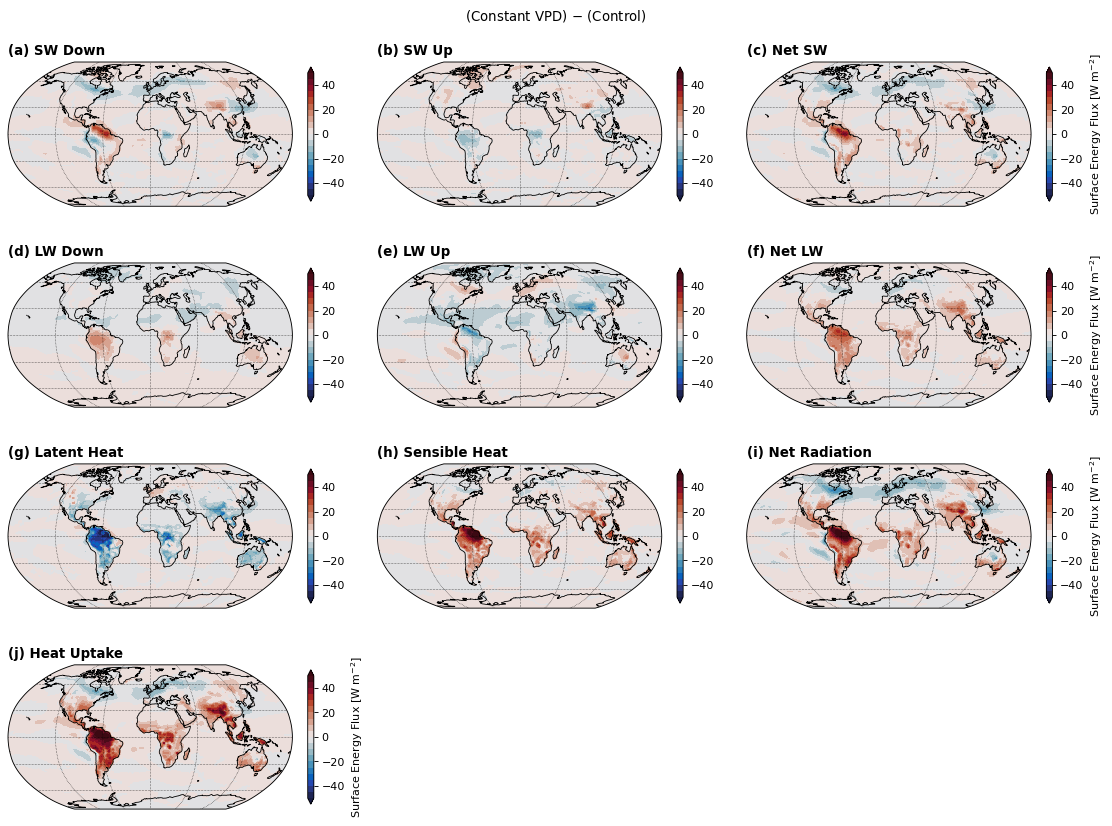

In [132]:
lon = fsns_ctl.lon
mapproj = ccrs.Robinson()
cmap = cmo.balance
cflevels = np.arange(-50,50.1,5)
cbticks = [-40,-20,0,20,40]
cblabel = 'Surface Energy Flux [W m$^{-2}$]'

fig,axes = plt.subplots(4,3,figsize=(14,10.67),subplot_kw={'projection':mapproj})
ax = axes.ravel()

cf_fsds = cds.cyclic_contourf(ax[0], fsds_vpd.mean(dim='time')-fsds_ctl.mean(dim='time'),
                              levels=cflevels, cmap=cmap, extend='both',
                              transform=ccrs.PlateCarree())

cf_fsus = cds.cyclic_contourf(ax[1], fsus_vpd.mean(dim='time')-fsus_ctl.mean(dim='time'),
                              levels=cflevels, cmap=cmap, extend='both',
                              transform=ccrs.PlateCarree())

cf_fsns = cds.cyclic_contourf(ax[2], fsns_vpd.mean(dim='time')-fsns_ctl.mean(dim='time'),
                              levels=cflevels, cmap=cmap, extend='both',
                              transform=ccrs.PlateCarree())

cf_flds = cds.cyclic_contourf(ax[3], flds_vpd.mean(dim='time')-flds_ctl.mean(dim='time'),
                              levels=cflevels, cmap=cmap, extend='both',
                              transform=ccrs.PlateCarree())

cf_flus = cds.cyclic_contourf(ax[4], flus_vpd.mean(dim='time')-flus_ctl.mean(dim='time'),
                              levels=cflevels, cmap=cmap, extend='both',
                              transform=ccrs.PlateCarree())

cf_flns = cds.cyclic_contourf(ax[5], flns_vpd.mean(dim='time')-flns_ctl.mean(dim='time'),
                              levels=cflevels, cmap=cmap, extend='both',
                              transform=ccrs.PlateCarree())

cf_lhfx = cds.cyclic_contourf(ax[6], lhflx_vpd.mean(dim='time')-lhflx_ctl.mean(dim='time'),
                              levels=cflevels, cmap=cmap, extend='both',
                              transform=ccrs.PlateCarree())

cf_shfx = cds.cyclic_contourf(ax[7], shflx_vpd.mean(dim='time')-shflx_ctl.mean(dim='time'),
                              levels=cflevels, cmap=cmap, extend='both',
                              transform=ccrs.PlateCarree())

cf_nrad = cds.cyclic_contourf(ax[8], nrad_vpd.mean(dim='time')-nrad_ctl.mean(dim='time'),
                              levels=cflevels, cmap=cmap, extend='both',
                              transform=ccrs.PlateCarree())

cf_stor = cds.cyclic_contourf(ax[9], stor_vpd.mean(dim='time')-stor_ctl.mean(dim='time'),
                              levels=cflevels, cmap=cmap, extend='both',
                              transform=ccrs.PlateCarree())

ax[10].remove()
ax[11].remove()

subplot_titles = ['(a) SW Down',
                  '(b) SW Up',
                  '(c) Net SW',
                  '(d) LW Down',
                  '(e) LW Up',
                  '(f) Net LW',
                  '(g) Latent Heat',
                  '(h) Sensible Heat',
                  '(i) Net Radiation',
                  '(j) Heat Uptake']

for i,a in enumerate(ax[:10]):
    a.coastlines(lw=0.75)
    cds.add_cartopy_gridlines(a, mapproj)
    a.set_title(subplot_titles[i], loc='left', fontweight='bold')
    
    cb = fig.colorbar(cf_flns, ax=ax[i], fraction=0.02)    
    cb.set_ticks(cbticks)
    if i%3 == 2 or i == 9:
        cb.set_label(cblabel)

fig.suptitle('(Constant VPD) $-$ (Control)')
fig.tight_layout()

### Evapotranspiration

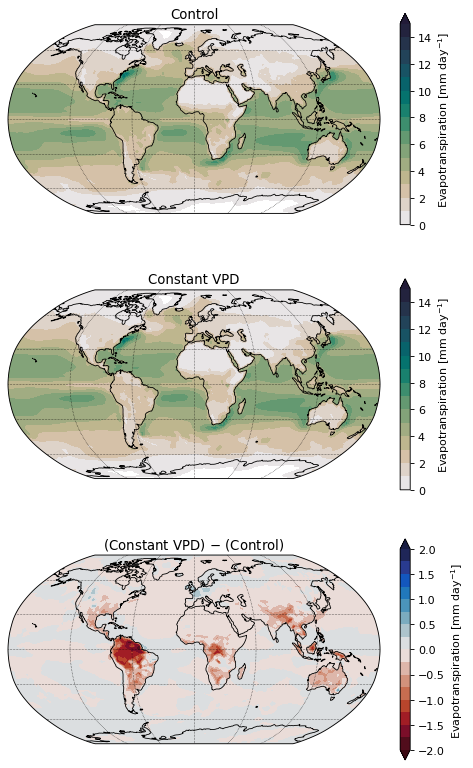

In [147]:
lon = et_ctl.lon
mapproj = ccrs.Robinson()
cmap = cmo.rain
cflevels = np.arange(0,15.1,1)
cbticks = [0,5,10,15]
cblabel = 'Evapotranspiration [mm day$^{-1}$]'

fig,axes = plt.subplots(3,1,figsize=(6,10),subplot_kw={'projection':mapproj})
ax = axes.ravel()

cf_et_ctl = cds.cyclic_contourf(ax[0], et_ctl.mean(dim='time'),
                               levels=cflevels, cmap=cmap, extend='max',
                               transform=ccrs.PlateCarree())
cb_et_ctl = fig.colorbar(cf_et_ctl, ax=ax[0], fraction=0.025, label=cblabel)    
cb.set_ticks(cbticks)
ax[0].set_title('Control')

cf_et_vpd = cds.cyclic_contourf(ax[1], et_vpd.mean(dim='time'),
                               levels=cflevels, cmap=cmap, extend='max',
                               transform=ccrs.PlateCarree())
cb_et_vpd = fig.colorbar(cf_et_vpd, ax=ax[1], fraction=0.025, label=cblabel)    
cb.set_ticks(cbticks)
ax[1].set_title('Constant VPD')

cf_et = cds.cyclic_contourf(ax[2], et_vpd.mean(dim='time')-et_ctl.mean(dim='time'),
                            levels=np.arange(-2,2.01,0.25), cmap=cmo.balance_r, extend='both',
                            transform=ccrs.PlateCarree())
cb_et = fig.colorbar(cf_et, ax=ax[2], fraction=0.025, label=cblabel)
cb.set_ticks([-2,-1,0,1,2])
ax[2].set_title('(Constant VPD) $-$ (Control)')

for a in ax:
    a.coastlines(lw=0.75)
    cds.add_cartopy_gridlines(a, mapproj)
    
fig.tight_layout()